In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, ReLU, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.63.19.202:8470']


In [3]:
# loading and splitting the dataset into training and testing data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

val_size = 0.1

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=val_size, random_state=42
)

# one-hot encoding the integer labels
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

# converting np arrays of uint8 dtype into tensors
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [4]:
# performing image augmentations
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_brightness(image, max_delta=0.2)

    image = tf.image.random_crop(image, size=[27, 27, 3])
    image = tf.image.resize(image, size=[32, 32], method=tf.image.ResizeMethod.LANCZOS3)

    return image, label

augmented_dataset = train_dataset.map(augment_data)
train_dataset = train_dataset.concatenate(augmented_dataset)

In [5]:
# normalizing the images in our datasets
def normalize_images(image, label):
    image = image/255.0

    return image, label

train_dataset = train_dataset.map(normalize_images)
val_dataset = val_dataset.map(normalize_images)
x_test = x_test/255.0

# shuffling and batching our datasets
batch_size=128

train_dataset = train_dataset.shuffle(buffer_size=90000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [6]:
# function takes as input lr and decay_rate which are float values and exp_decay which is a boolean value
def build_model(lr, decay_rate, exp_decay):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(400, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(400, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(400, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(GlobalAveragePooling2D())

    model.add(Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.4))

    model.add(Dense(10, activation='softmax', kernel_initializer='he_normal'))

    lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                        decay_steps=3520,
                                                        decay_rate=decay_rate,
                                                        staircase=True)

    if exp_decay:
        optimizer = optimizers.Adam(lr_schedule)
    else:
        optimizer = optimizers.Adam(lr)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [7]:
# model checkpointing to save the weights corresponding to the lowest val_loss
checkpoint_callback = ModelCheckpoint(filepath='best_model_weights.h5',
                                      monitor='val_loss',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=0)

In [8]:
# training the model
with tpu_strategy.scope():
    model = build_model(lr=0.0008, decay_rate=0.3, exp_decay=True)

history= model.fit(train_dataset, epochs=40, validation_data=val_dataset, verbose=2, callbacks=[checkpoint_callback])

Epoch 1/40
704/704 - 33s - loss: 3.9024 - accuracy: 0.4996 - val_loss: 2.0807 - val_accuracy: 0.5248 - 33s/epoch - 47ms/step
Epoch 2/40
704/704 - 21s - loss: 1.6026 - accuracy: 0.6564 - val_loss: 2.4300 - val_accuracy: 0.4222 - 21s/epoch - 30ms/step
Epoch 3/40
704/704 - 22s - loss: 1.4195 - accuracy: 0.6965 - val_loss: 2.1392 - val_accuracy: 0.4716 - 22s/epoch - 31ms/step
Epoch 4/40
704/704 - 22s - loss: 1.3311 - accuracy: 0.7225 - val_loss: 1.7779 - val_accuracy: 0.5492 - 22s/epoch - 32ms/step
Epoch 5/40
704/704 - 22s - loss: 1.2650 - accuracy: 0.7429 - val_loss: 1.7190 - val_accuracy: 0.5884 - 22s/epoch - 32ms/step
Epoch 6/40
704/704 - 23s - loss: 0.9133 - accuracy: 0.8272 - val_loss: 0.8607 - val_accuracy: 0.8180 - 23s/epoch - 32ms/step
Epoch 7/40
704/704 - 23s - loss: 0.7936 - accuracy: 0.8440 - val_loss: 0.8601 - val_accuracy: 0.8126 - 23s/epoch - 32ms/step
Epoch 8/40
704/704 - 22s - loss: 0.7382 - accuracy: 0.8589 - val_loss: 0.8677 - val_accuracy: 0.8166 - 22s/epoch - 31ms/step


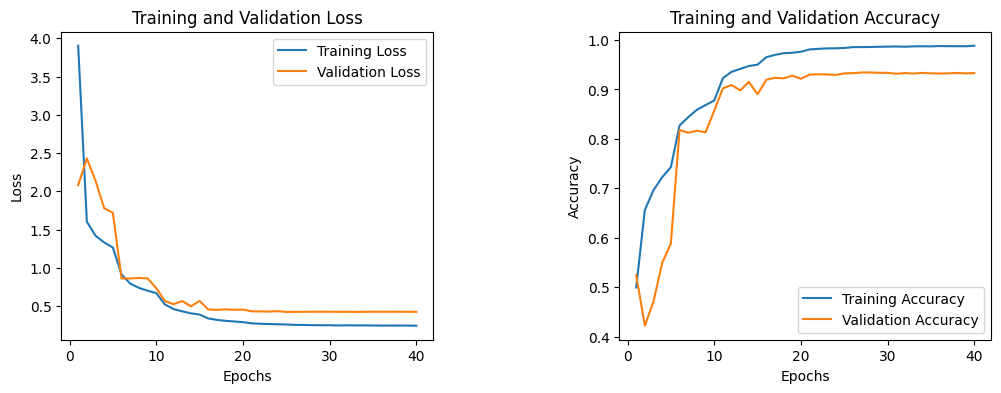

In [11]:
# plotting the loss and accuracy values for training and validation
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epochs = list(range(1, len(training_loss) + 1))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(epochs, training_loss, label='Training Loss')
axs[0].plot(epochs, validation_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, training_acc, label='Training Accuracy')
axs[1].plot(epochs, validation_acc, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.subplots_adjust(wspace=0.5)
plt.show()

In [9]:
# evaluating the model on test data
model.load_weights('best_model_weights.h5')
model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 17s 31ms/step - loss: 0.4406 - accuracy: 0.9281


[0.44056546688079834, 0.9280999898910522]